In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
k_indices = build_k_indices(y, 4, 1)
print(k_indices, "ee",np.delete(k_indices, 1,0), x.shape, x[4])

[[27 35 40 38  2  3 48 29 46 31 32 39]
 [21 36 19 42 49 26 22 13 41 17 45 24]
 [23  4 33 14 30 10 28 44 34 18 20 25]
 [ 6  7 47  1 16  0 15  5 11  9  8 12]] ee [[27 35 40 38  2  3 48 29 46 31 32 39]
 [23  4 33 14 30 10 28 44 34 18 20 25]
 [ 6  7 47  1 16  0 15  5 11  9  8 12]] (50,) 3.380873836


In [5]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    x_train = x[np.delete(k_indices, k,0)].ravel()
    y_train = y[np.delete(k_indices, k,0)].ravel()
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    x_poly_tain = build_poly(x_train, degree)
    x_poly_test = build_poly(x_test, degree)
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    w_optimal, mse = ridge_regression(y_train, x_poly_tain, lambda_)
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    loss_tr = np.sqrt(2*mse)
    loss_te = np.sqrt(2*compute_mse(y_test,x_poly_test,w_optimal))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    return loss_tr, loss_te

0.5131379494031016 0.02212216291070448
0.5337341197053957 0.0012689610031679222
0.2978200696551001 0.0003562247890262444
0.29200415223222226 0.0017433288221999873
0.2941683614567406 0.02212216291070448
0.3047515189723306 0.0001
0.2895728057801092 0.004520353656360241
0.29777099561255194 0.011721022975334805


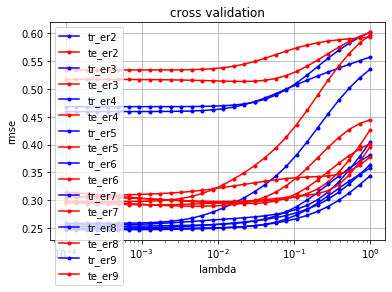

In [6]:
from plots import cross_validation_visualization

def cross_validation_demo(degree):
    seed = 1
    #degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for lambda_ in lambdas:
        loss_tr = []
        loss_te = []
        for k in range(k_fold):
            temp_tr, temp_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_tr.append(temp_tr)
            loss_te.append(temp_te)
        
        rmse_tr.append(np.average(loss_tr))
        rmse_te.append(np.average(loss_te))
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te,degree)
    min_test_err = np.min(rmse_te)
    min_test_lambda = lambdas[np.argmin(rmse_te)]
    return np.min(rmse_te), min_test_lambda

for d in range(2,10):
    res, res2 = cross_validation_demo(d)
    print (res, res2)
#deg 9 has min test err avec lambda 0.004520353656360241

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

(100, 9)


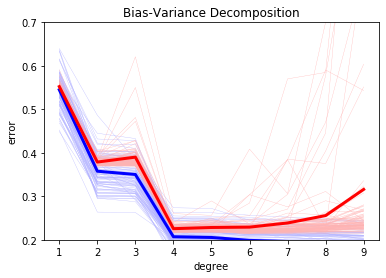

In [7]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    print(rmse_tr.shape)
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        # split data with a specific seed: TODO
        for index, d in enumerate(degrees):
            x_poly_tain = build_poly(x_train, d)
            x_poly_test = build_poly(x_test, d)
            w_optimal, mse = least_squares(y_train, x_poly_tain)
            rmse_tr[index_seed,index] = np.sqrt(mse)
            rmse_te[index_seed,index] = np.sqrt(compute_mse(y_test,x_poly_test,w_optimal))
            #print(rmse_tr[index_seed,index], rmse_te[index_seed,index])

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()